# TIC-HEAP Cirta Particle Classification Challenge

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

In [2]:
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Load and pre-process the data

In [4]:
train_path = '../data/train/combined.pkl'
test_path = '../data/test/data_test_file.pkl'

In [5]:
with open(train_path, 'rb') as f:
    training_data = pkl.load(f)

In [6]:
classes2name = {11: 'electron', 13: 'muon', 211: 'pion', 321: 'kaon', 2212: 'proton'}
classes2int = {11:0, 13:1, 211:2, 321:3, 2212:4}

In [7]:
def show_images(data):
    fig = plt.figure(figsize=(25, 4))
    
    for i in np.arange(20):
        ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
        ax.imshow(data[0][i], cmap='gray')
        ax.set_title(classes2name[data[1][i]])

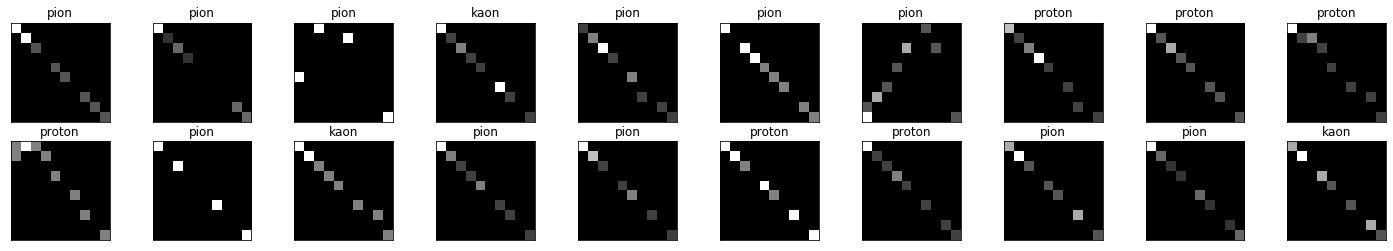

In [8]:
show_images(training_data)

**separate images from labels**

In [9]:
training_data.shape

(2, 1176475)

In [10]:
train_images = np.zeros((1176475, 10, 10))

for i in range(1176475):
    train_images[i,:] = training_data[0][i]

In [11]:
train_labels = np.zeros((1176475))

for i in range(1176475):
    train_labels[i] = classes2int[training_data[1][i]]

**normalize the images**

Mean subtraction removes the mean of the dataset form each data point. 

<!--Then we normalize by dividing each zero-centred dimension by its standard deviation. This makes convergence faster while training the network. -->

In [12]:
max, min = np.max(train_images), np.min(train_images)
max, min

(12.0, 0.0)

In [13]:
train_images = (train_images - min) / (max - min)

In [14]:
print(f'After-> min value: {np.min(train_images)}  max value: {np.max(train_images)}')

After-> min value: 0.0  max value: 1.0


## Create dataset and dataloaders

In [15]:
train_images, train_labels = torch.from_numpy(train_images), torch.from_numpy(train_labels.astype(np.int64))

In [16]:
train_images = train_images[:, None, :, :] # insert empty dimension at the channels axis

In [17]:
train_dataset = TensorDataset(train_images, train_labels)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

## Model

In [19]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 5 * 5, 5)
    
    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        #out = torch.relu(self.bn2(self.conv2(out)))
        out = out.view(-1, 32 * 5 * 5)
        out = torch.log_softmax(self.fc1(out), dim=1)
        return out

In [20]:
model = Model()
model = model.to(device)

## Loss function and optimizer

In [21]:
criterion = nn.NLLLoss()

In [22]:
optimizer = optim.AdamW(model.parameters(), lr=0.01)

## Training loop

In [23]:
n_epochs = 20
training_losses = []

In [24]:
for epoch in range(1, n_epochs + 1):
    running_train_loss = 0.0
    train_acc = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device, dtype=torch.float), labels.to(device)
        
        # zero out the gradients of the optimizer
        optimizer.zero_grad()
        # forward pass
        log_ps = model(images)
        # find the loss
        train_loss = criterion(log_ps, labels)
        # backpropagate
        train_loss.backward()
        optimizer.step()
        
        running_train_loss += train_loss.item()
        # find accuracy
        probs = torch.exp(log_ps)
        _, top_class = probs.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_acc += torch.mean(equals.type(torch.FloatTensor))
        
    else:
        # print stats
        print(f'Epoch: {epoch}/{n_epochs} | Training loss: {running_train_loss/len(train_loader):.3f} | '
              f'Accuracy: {train_acc/len(train_loader)*100:.3f}')

Epoch: 1/20 | Training loss: 0.715 | Accuracy: 77.002
Epoch: 2/20 | Training loss: 0.713 | Accuracy: 77.014
Epoch: 3/20 | Training loss: 0.713 | Accuracy: 77.013
Epoch: 4/20 | Training loss: 0.713 | Accuracy: 77.014
Epoch: 5/20 | Training loss: 0.713 | Accuracy: 77.014
Epoch: 6/20 | Training loss: 0.713 | Accuracy: 77.013
Epoch: 7/20 | Training loss: 0.713 | Accuracy: 77.014
Epoch: 8/20 | Training loss: 0.713 | Accuracy: 77.013
Epoch: 9/20 | Training loss: 0.713 | Accuracy: 77.013
Epoch: 10/20 | Training loss: 0.714 | Accuracy: 77.014
Epoch: 11/20 | Training loss: 0.714 | Accuracy: 77.014
Epoch: 12/20 | Training loss: 0.714 | Accuracy: 77.013
Epoch: 13/20 | Training loss: 0.714 | Accuracy: 77.014
Epoch: 14/20 | Training loss: 0.714 | Accuracy: 77.013
Epoch: 15/20 | Training loss: 0.714 | Accuracy: 77.014
Epoch: 16/20 | Training loss: 0.714 | Accuracy: 77.014
Epoch: 17/20 | Training loss: 0.714 | Accuracy: 77.015
Epoch: 18/20 | Training loss: 0.714 | Accuracy: 77.013
Epoch: 19/20 | Trai